In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Merging Data

We start off by merging data according to the wikipedia pageviews files.

In [2]:
from pathlib import Path

path = Path.cwd()
data_path = path.parent / 'data' / 'raw'

countries = ['austria', 'belgium', 'germany', 'italy', 'netherlands']

df = {}

years = [2007+i for i in range(13)]

for country_name in countries :
    frames = []
    for year in years :
        wiki_path = data_path / ('wikipedia_'+country_name) / 'complete' / (str(year)+'.csv')

        if wiki_path.exists() and wiki_path.is_file() :
            df_wiki = pd.read_csv(wiki_path)
            df_wiki = df_wiki.rename(
                columns={
                    'Week': 'week'
                }
            )

            incidence_path1 = data_path / country_name / 'complete' / (str(year-1)+'_'+str(year)+'.csv')
            incidence_path2 = data_path / country_name / 'complete' / (str(year)+'_'+str(year+1)+'.csv')

            if incidence_path1.exists() and incidence_path1.is_file() :
                df_incidence1 = pd.read_csv(incidence_path1)
                df_wiki = pd.merge(df_incidence1, df_wiki, on='week', how='right')

                df_wiki.head()

            if incidence_path2.exists() and incidence_path2.is_file() :
                df_incidence2 = pd.read_csv(incidence_path2)
                df_wiki = pd.merge(df_incidence2, df_wiki, on='week', how='right')

            frames.append(df_wiki)

    df_country = pd.concat(frames)
    df_country['incidence'] = df_country['incidence'].fillna(0)
    df_country['incidence_x'] = df_country['incidence_x'].fillna(0)
    df_country['incidence_y'] = df_country['incidence_y'].fillna(0)

    df_country['incidence'] = df_country['incidence'] + df_country['incidence_x'] + df_country['incidence_y']
    df_country.drop(['incidence_x', 'incidence_y'], axis=1)

Here we see tha in the final dataframe for each country, there are a few rows for which we have the wiki pageviews but the incidence data is missing as it isn't peak season. these weeks too are out of question for us.

In [4]:

for country_name in countries :
    frames = []
    for year in years :
        incidence_path = data_path / country_name / 'complete' / (str(year)+'_'+str(year+1)+'.csv')

        if incidence_path.exists() and incidence_path.is_file() :
            df_incidence = pd.read_csv(incidence_path)

            wiki_path1 = data_path / ('wikipedia_'+country_name) / 'complete' / (str(year)+'.csv')
            wiki_path2 = data_path / ('wikipedia_'+country_name) / 'complete' / (str(year+1)+'.csv')

            if wiki_path1.exists() and wiki_path1.is_file() :
                df_wiki1 = pd.read_csv(wiki_path1)
                df_wiki1 = df_wiki1.rename(columns={'Week': 'week'})
                df_incidence = pd.merge(df_wiki1, df_incidence, on='week', how='right')

            if wiki_path2.exists() and wiki_path2.is_file() :
                df_wiki2 = pd.read_csv(wiki_path2)
                df_wiki2 = df_wiki2.rename(columns={'Week': 'week'})
                df_incidence = pd.merge(df_wiki2, df_incidence, on='week', how='right')

            for col_name in df_incidence.columns:
                if col_name[-1] == 'x':
                    if col_name[:-2]+'_y' in df_incidence.columns :
                        df_incidence[col_name[:-2]] = df_incidence[col_name].fillna(df_incidence[col_name[:-2]+'_y'])
                        df_incidence = df_incidence.drop(columns=[col_name, col_name[:-2]+'_y'])

            frames.append(df_incidence)

    df_country = pd.concat(frames)
    df_country['date'] = pd.to_datetime(df_country.week.add('-0'), format='%Y-%W-%w')
    df_country = df_country.sort_values(by="date")
    df[country_name] = df_country

Finally we end up with a dictionary with the key as the country name and the value as a pandas dataframe specific to that country.
I was wondering if I should make the week number as a parameter as well. After all even time of the year is a paramter right?

However, I'm unsure if it would give correct results when we apply poisson regression as it isn't really count based data.

I think that will be better suited to some kind of a parabolic curve maybe?

I don't know how right that will be to find the average peak in the weeks and transform the week parameter to week_squared = (week-mean)^2

We'll try that later to see if something on those lines gives a better output.

In [5]:
df['austria'].columns

Index(['"RTS,S"', 'Acetaldehydsyndrom', 'Achsensymptom',
       'Adeno-assoziierte_Viren', 'Adenovirusimpfstoff', 'Adipsie', 'Adynamie',
       'Aggravation', 'Agitation_(Medizin)', 'Akantholyse',
       ...
       'Zohlen-Zeichen', 'Zoonose', 'Zwerchfellhochstand', 'Zyanose', 'cases',
       'incidence', 'week', 'Ödem', 'Übelkeit', 'date'],
      dtype='object', length=385)

In [5]:
df['austria']['incidence'].describe()

count     156.000000
mean      880.461157
std       429.093467
min         0.000000
25%       636.664425
50%       816.951024
75%      1120.661459
max      2052.819744
Name: incidence, dtype: float64

In [ ]:
#histogram
sns.distplot(df['austria']['incidence'])

#### Characteristics we can derive from the graph:
    Deviates from the normal distribution.
    Has appreciable positive skewness.
    Shows peakedness.

#### Skewness and Kurtosis
Skewness is a measure of the symmetry in a distribution.  A symmetrical dataset will have a skewness equal to 0.  So, a normal distribution will have a skewness of 0.   Skewness essentially measures the relative size of the two tails.

Kurtosis is a measure of the combined sizes of the two tails.  It measures the amount of probability in the tails.  The value is often compared to the kurtosis of the normal distribution, which is equal to 3.  If the kurtosis is greater than 3, then the dataset has heavier tails than a normal distribution (more in the tails).  If the kurtosis is less than 3, then the dataset has lighter tails than a normal distribution (less in the tails).  Careful here.  Kurtosis is sometimes reported as “excess kurtosis.”  Excess kurtosis is determined by subtracting 3 form the kurtosis.  This makes the normal distribution kurtosis equal 0.  Kurtosis originally was thought to measure the peakedness of a distribution.   Though you will still see this as part of the definition in many places, this is a misconception.

Skewness and kurtosis involve the tails of the distribution.


In [6]:
#skewness and kurtosis
print("Skewness: %f" % df['austria']['incidence'].skew())
print("Kurtosis: %f" % df['austria']['incidence'].kurt())

Skewness: 0.277430
Kurtosis: 0.073994


Here the kurtosis is less than 3.

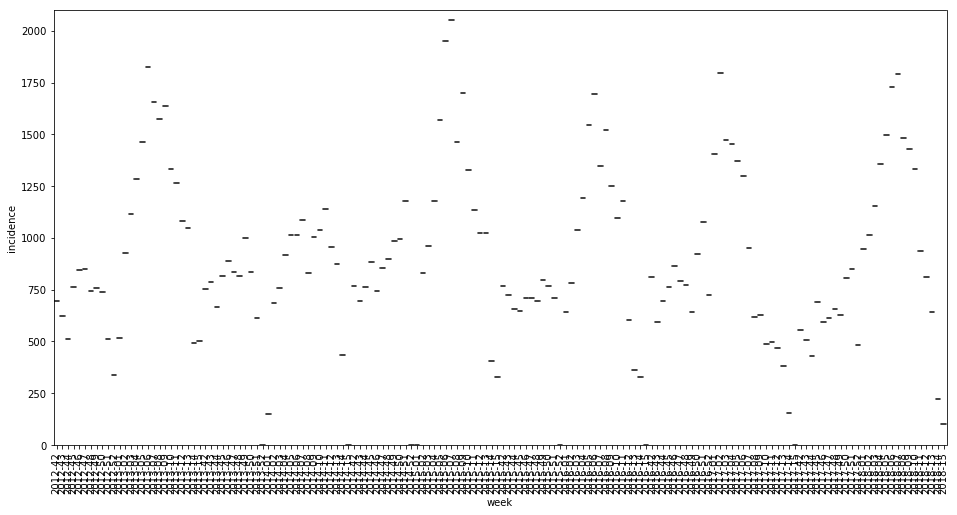

In [7]:
data = pd.concat([df['austria']['incidence'], df['austria']['week']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='week', y="incidence", data=data)
fig.axis(ymin=0, ymax=2100);
plt.xticks(rotation=90);

#### Correlation matrix (Heatmap style)

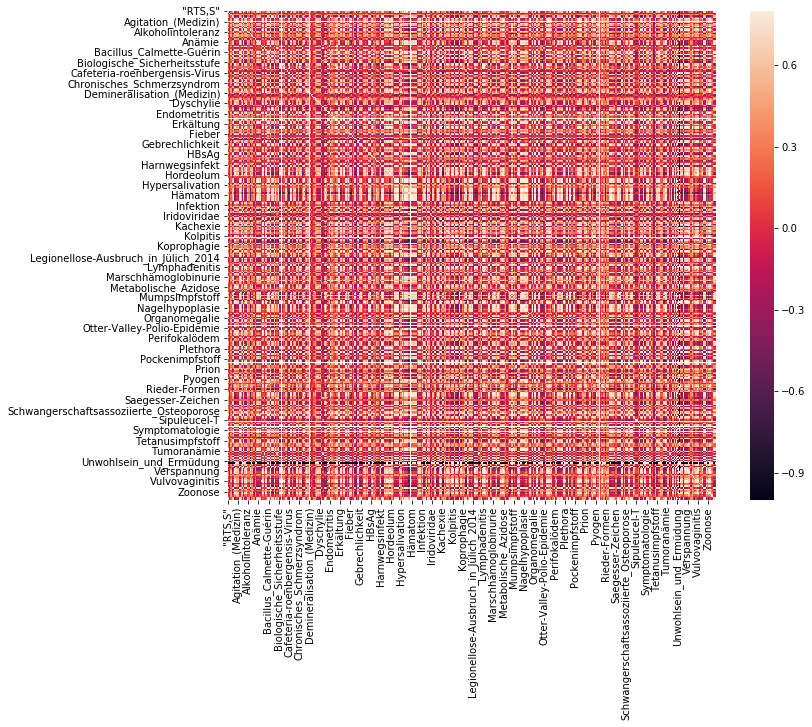

In [9]:
#correlation matrix
corrmat = df['austria'].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

There is too many features to see things clearly

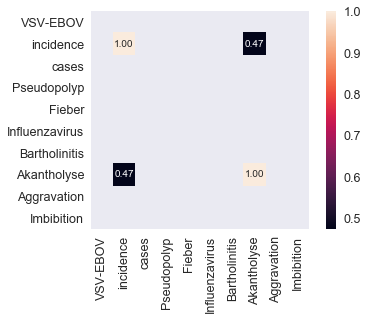

In [10]:
#incidence correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'incidence')['incidence'].index
cm = np.corrcoef(df['austria'][cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [11]:
df['austria'].corr()['incidence'].describe()

count    368.000000
mean       0.133769
std        0.164760
min       -0.567459
25%        0.009233
50%        0.125328
75%        0.229082
max        1.000000
Name: incidence, dtype: float64

In [12]:
corrmat.describe()

,"""RTS,S""",Acetaldehydsyndrom,Achsensymptom,Adeno-assoziierte_Viren,Adenovirusimpfstoff,Adipsie,Adynamie,Aggravation,Agitation_(Medizin),Akantholyse,...,Zervizitis,Zikavirus-Epidemie_2015/2016,Zohlen-Zeichen,Zoonose,Zwerchfellhochstand,Zyanose,cases,incidence,Ödem,Übelkeit
count,0.0,368.000000,367.000000,368.000000,368.000000,368.000000,367.000000,368.000000,0.0,368.000000,...,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,366.000000,368.000000,368.000000,368.000000
mean,NaN,0.287076,-0.119815,0.286117,0.062979,0.335131,0.208111,0.276812,NaN,0.217492,...,0.270011,0.262660,0.191718,0.249487,0.170789,0.338700,0.167324,0.133769,0.289819,0.291445
std,NaN,0.335658,0.182677,0.204273,0.417197,0.404657,0.510900,0.308287,NaN,0.351823,...,0.461125,0.431631,0.507096,0.221683,0.516786,0.416258,0.228351,0.164760,0.470439,0.467434
min,NaN,-1.000000,-0.729872,-1.000000,-1.000000,-1.000000,-0.674625,-0.319610,NaN,-0.343138,...,-1.000000,-0.624487,-0.664897,-1.000000,-1.000000,-0.592646,-1.000000,-0.567459,-1.000000,-0.667909
25%,NaN,0.011178,-0.194171,0.164471,-0.306742,0.011481,-0.325067,-0.016619,NaN,-0.164508,...,-0.105863,-0.096577,-0.349908,0.120683,-0.373133,0.006774,-0.060040,0.009233,-0.100941,-0.106605
50%,NaN,0.280924,-0.133455,0.270793,-0.040061,0.315313,0.269147,0.283688,NaN,0.261915,...,0.232000,0.194696,0.248690,0.238827,0.221424,0.358306,0.178384,0.125328,0.226571,0.212999
75%,NaN,0.595244,-0.031320,0.437262,0.507791,0.710041,0.702167,0.564954,NaN,0.564908,...,0.721329,0.653405,0.683622,0.417243,0.667382,0.743789,0.348201,0.229082,0.737648,0.741899
max,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Missing data

Important questions when thinking about missing data:

    How prevalent is the missing data?
    Is missing data random or does it have a pattern?

The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hiding an inconvenient truth.

In [13]:
#missing data
total = df['austria'].isnull().sum().sort_values(ascending=False)
percent = (df['austria'].isnull().sum()/df['austria'].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Otitis_externa,156,1.000000
Syndrom,156,1.000000
Epidemie,155,0.993590
VSV-EBOV,154,0.987179
Bartholinitis,150,0.961538
Influenzavirus,144,0.923077
Pseudopolyp,141,0.903846
Klosneuvirus,141,0.903846
Sepsis,138,0.884615
Mastitis,138,0.884615


In [14]:
missing_data.describe()

,Total,Percent
count,385.000000,385.000000
mean,17.561039,0.112571
std,38.707531,0.248125
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,156.000000,1.000000


In [15]:
austria = df['austria']
austria

,"""RTS,S""",Acetaldehydsyndrom,Achsensymptom,Adeno-assoziierte_Viren,Adenovirusimpfstoff,Adipsie,Adynamie,Aggravation,Agitation_(Medizin),Akantholyse,...,Zohlen-Zeichen,Zoonose,Zwerchfellhochstand,Zyanose,cases,incidence,week,Ödem,Übelkeit,date
15,0.0,216.0,0.0,114.0,0.0,150.0,317.0,421.0,0.0,150.0,...,294.0,1437.0,416.0,2733.0,319.0,696.308908,2012-42,58.0,11.0,2012-10-21
16,0.0,146.0,0.0,111.0,0.0,89.0,356.0,516.0,0.0,143.0,...,316.0,1477.0,402.0,2736.0,279.0,624.244865,2012-43,59.0,9.0,2012-10-28
17,0.0,100.0,0.0,124.0,0.0,86.0,328.0,448.0,0.0,145.0,...,333.0,1511.0,373.0,2661.0,224.0,512.046816,2012-44,53.0,17.0,2012-11-04
18,0.0,117.0,0.0,135.0,0.0,81.0,383.0,474.0,0.0,180.0,...,395.0,1515.0,514.0,2958.0,383.0,761.567676,2012-45,57.0,14.0,2012-11-11
19,0.0,112.0,0.0,130.0,0.0,67.0,390.0,523.0,0.0,136.0,...,396.0,1648.0,512.0,2997.0,397.0,845.886690,2012-46,65.0,15.0,2012-11-18
20,0.0,131.0,0.0,186.0,0.0,73.0,379.0,473.0,0.0,136.0,...,320.0,1569.0,515.0,3011.0,382.0,851.424241,2012-47,11.0,3.0,2012-11-25
21,0.0,84.0,0.0,126.0,0.0,90.0,419.0,495.0,0.0,164.0,...,366.0,1478.0,400.0,3549.0,437.0,741.897696,2012-48,0.0,0.0,2012-12-02
22,0.0,85.0,0.0,139.0,0.0,82.0,466.0,467.0,0.0,155.0,...,305.0,1450.0,459.0,2592.0,429.0,757.081091,2012-49,0.0,0.0,2012-12-09
23,0.0,110.0,0.0,140.0,0.0,89.0,426.0,483.0,0.0,139.0,...,299.0,2187.0,410.0,2443.0,394.0,739.114938,2012-50,0.0,0.0,2012-12-16
24,0.0,76.0,0.0,129.0,0.0,91.0,357.0,385.0,0.0,105.0,...,224.0,1348.0,377.0,2301.0,168.0,513.400361,2012-51,0.0,0.0,2012-12-23


According to Hair et al. (2013), four assumptions should be tested:

Normality - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'incidence' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

Homoscedasticity - I just hope I wrote it right. Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

Linearity- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

Absence of correlated errors - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

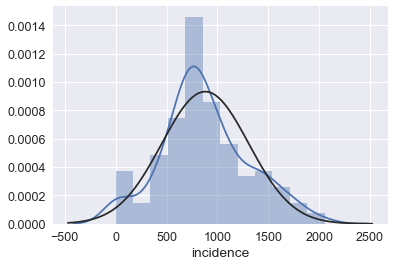

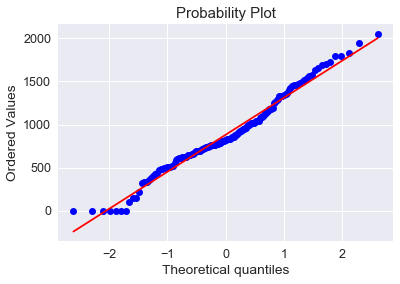

In [19]:
#histogram and normal probability plot
sns.distplot(df['austria']['incidence'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['austria']['incidence'], plot=plt)

Ok, 'incidence' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.
